In [116]:
from torchvision.transforms.functional import to_tensor
from ultralytics import YOLO
from PIL import Image
import torch

from transformation import detect_objects, draw_boxes, apply_patch_to_image

# Patch image and prediction on the original image

---

In [117]:
# Load the original image
image_path = "original_images/persons2.png"
original_image = Image.open(image_path)
original_size = original_image.size

patch_image_path = "patches/v4tiny.png"
patch = Image.open(patch_image_path)

yolo_model = YOLO("yolov5n.pt")

TARGET_CLASS = 'person'
SIZE_MULTIPLE = 0.6

In [118]:
# Step 1: Detect objects
detection_results, resized_size = detect_objects(original_image, yolo_model)


0: 448x640 4 persons, 43.8ms
Speed: 1.5ms preprocess, 43.8ms inference, 5.7ms postprocess per image at shape (1, 3, 448, 640)


In [119]:
# Step 2: Draw boxes on the original image
image_with_boxes = draw_boxes(original_image.copy(), detection_results, resized_size, TARGET_CLASS)
# Convert the loaded patch image to a tensor before applying
patch_tensor = to_tensor(patch)

In [120]:
# Step 4: Apply the patch to the image
patched_image = apply_patch_to_image(original_image.copy(), patch_tensor, detection_results, resized_size, TARGET_CLASS, size_multiple=SIZE_MULTIPLE)

In [121]:
# Display or save the results
image_with_boxes.save("image_with_boxes.jpg")
# patched_image.save("patched_image.jpg")

# Optionally display the images
# image_with_boxes.show()
# patched_image.show()

# Predict on the patched image to test the patch

---

In [122]:
# Step 5: Detect objects in the patched image
patched_detection_results, _ = detect_objects(patched_image, yolo_model)

# Step 6: Draw boxes on the patched image based on the new detections
patched_image_with_boxes = draw_boxes(patched_image.copy(), patched_detection_results, resized_size, TARGET_CLASS)

# Save or display the patched image with new detection boxes
patched_image_with_boxes.save("patched_image_with_boxes.jpg")
# patched_image_with_boxes.show()


0: 448x640 4 persons, 1 sports ball, 3 teddy bears, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)


In [123]:
# Print detection results for the original image
print("Detection Results on Original Image:")
for i, bbox in enumerate(detection_results.boxes.xyxy):
    class_id = detection_results.boxes.cls[i]
    class_name = detection_results.names[class_id.item() if isinstance(class_id, torch.Tensor) else class_id]
    conf = detection_results.boxes.conf[i]
    print(f"Class: {class_name}, Confidence: {conf:.2f}, Box: {bbox.tolist()}")

# Print detection results for the patched image
print("\nDetection Results on Patched Image:")
for i, bbox in enumerate(patched_detection_results.boxes.xyxy):
    class_id = patched_detection_results.boxes.cls[i]
    class_name = patched_detection_results.names[class_id.item() if isinstance(class_id, torch.Tensor) else class_id]
    conf = patched_detection_results.boxes.conf[i]
    print(f"Class: {class_name}, Confidence: {conf:.2f}, Box: {bbox.tolist()}")


Detection Results on Original Image:
Class: person, Confidence: 0.91, Box: [329.17864990234375, 116.1265869140625, 409.24102783203125, 328.9501037597656]
Class: person, Confidence: 0.91, Box: [226.8689422607422, 103.13925170898438, 313.10882568359375, 296.859375]
Class: person, Confidence: 0.90, Box: [455.0115966796875, 65.75091552734375, 560.5938720703125, 341.68353271484375]
Class: person, Confidence: 0.87, Box: [86.1150894165039, 184.34945678710938, 175.93765258789062, 321.358642578125]

Detection Results on Patched Image:
Class: person, Confidence: 0.80, Box: [223.81732177734375, 102.36004638671875, 314.44525146484375, 296.0397644042969]
Class: person, Confidence: 0.79, Box: [328.48931884765625, 116.12994384765625, 409.48663330078125, 328.55487060546875]
Class: person, Confidence: 0.65, Box: [456.14739990234375, 65.36181640625, 561.1865844726562, 238.11285400390625]
Class: person, Confidence: 0.51, Box: [455.30743408203125, 65.60379028320312, 560.9586791992188, 339.5242614746094]
C

In [124]:
# Collect confidence scores for the target class 'car' from both original and patched images
original_confidences = [detection_results.boxes.conf[i].item() for i in range(len(detection_results.boxes.xyxy))
                        if detection_results.names[detection_results.boxes.cls[i].item()] == TARGET_CLASS]

patched_confidences = [patched_detection_results.boxes.conf[i].item() for i in range(len(patched_detection_results.boxes.xyxy))
                       if patched_detection_results.names[patched_detection_results.boxes.cls[i].item()] == TARGET_CLASS]

In [125]:
# Generate a random patch (as an example)
import numpy as np


def generate_random_patch(size):
    random_image = Image.fromarray(np.random.randint(0, 255, (size[1], size[0], 3), dtype=np.uint8))
    return random_image

# Apply a random patch to the image
random_patch = generate_random_patch(patch.size)
random_patch_tensor = to_tensor(random_patch)

# Apply the random patch to the original image (You might need to adjust the function or the way you apply it)
random_patched_image = apply_patch_to_image(original_image.copy(), random_patch_tensor, detection_results, resized_size, TARGET_CLASS, size_multiple=SIZE_MULTIPLE)

# Detect objects in the randomly patched image
random_patched_detection_results, _ = detect_objects(random_patched_image, yolo_model)

# Collect confidence scores for the target class 'person' from the randomly patched image
random_patched_confidences = [random_patched_detection_results.boxes.conf[i].item() for i in range(len(random_patched_detection_results.boxes.xyxy))
                              if random_patched_detection_results.names[random_patched_detection_results.boxes.cls[i].item()] == TARGET_CLASS]


random_patched_image_with_boxes = draw_boxes(random_patched_image.copy(), random_patched_detection_results, resized_size, TARGET_CLASS)

# Save or display the patched image with new detection boxes
random_patched_image_with_boxes.save("random_patched_image_with_boxes.jpg")

0: 448x640 4 persons, 9.0ms
Speed: 0.5ms preprocess, 9.0ms inference, 4.0ms postprocess per image at shape (1, 3, 448, 640)


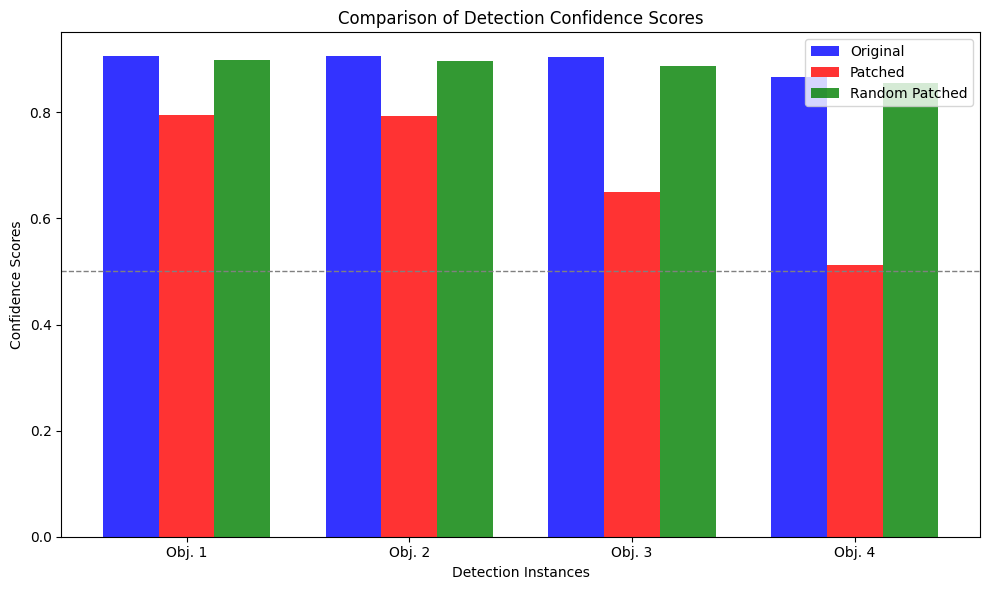

In [126]:
import matplotlib.pyplot as plt

# Assuming equal or less number of detections on all images, pad the shorter lists for equal length
max_len = max(len(original_confidences), len(patched_confidences), len(random_patched_confidences))
original_confidences += [0] * (max_len - len(original_confidences))
patched_confidences += [0] * (max_len - len(patched_confidences))
random_patched_confidences += [0] * (max_len - len(random_patched_confidences))

# Adjust the plotting code to include the new data
indices = np.arange(max_len)

plt.figure(figsize=(10, 6))
bar_width = 0.25
opacity = 0.8

plt.bar(indices - bar_width, original_confidences, bar_width, alpha=opacity, color='b', label='Original')
plt.bar(indices, patched_confidences, bar_width, alpha=opacity, color='r', label='Patched')
plt.bar(indices + bar_width, random_patched_confidences, bar_width, alpha=opacity, color='g', label='Random Patched')

plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Detection Instances')
plt.ylabel('Confidence Scores')
plt.title('Comparison of Detection Confidence Scores')
plt.xticks(indices, [f'Obj. {i+1}' for i in indices])
plt.legend()

plt.tight_layout()
plt.show()